Вам необходимо построить модель, которая на основании данных, поступающих каждую
минуту, определяют качество продукции, производимое на обжиговой машине.
Обжиговая машина представляет собой агрегат, состоящий из 5 одинаковых по размеру
камер, в каждой камере установлено по 3 датчика температур. Кроме этого, для данной
задачи Вы собрали данные о высоте слоя сырья и его влажности. Высота слоя и влажность
измеряются при входе сырья в машину. Сырье проходит через обжиговую машину за час.

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LassoCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.pipeline import Pipeline

**Ввод данных**

In [3]:
X_data = pd.read_csv("drive/My Drive/Colab Notebooks/X_data.csv", sep = ';').rename(columns={'Unnamed: 0': 'date'})

In [4]:
Y_train = pd.read_csv("drive/My Drive/Colab Notebooks/Y_train.csv", sep = ';', header = None).rename(columns={0: 'date', 1: 'quality'})

In [5]:
Y_submit = pd.read_csv("drive/My Drive/Colab Notebooks/Y_submit.csv", sep = ';', header = None).rename(columns={0: 'date', 1: 'quality'})

**Краткое исследование данных**

In [6]:
def get_time_begin(time_end: str) -> str:
    return str(pd.Timestamp(time_end) - pd.Timedelta('1 hour'))

Есть предположение, что температура в датчиках ведёт себя циклически. Построим графики температур

In [ ]:
def draw_temperatures(df, n = 5, m = 3):
    fig, axes = plt.subplots(nrows=n, ncols=m)
    for i in range(0, n):
        for j in range(0, m):
            cur = 'T_data_{0}_{1}'.format(i + 1, j + 1)
            if n > 1:
                df[cur].plot(ax=axes[i, j], figsize = (16, 14), grid = True, title = cur)
            else:
                df[cur].plot(ax=axes[j], figsize = (7, 2), grid = True, title = cur)
    if n > 1:
        plt.subplots_adjust(wspace=0.2, hspace=0.3)
    else:
        plt.subplots_adjust(wspace=0.5, hspace=0.1)

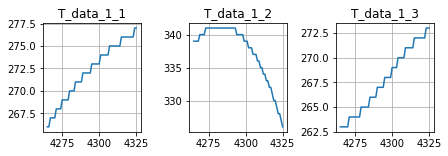

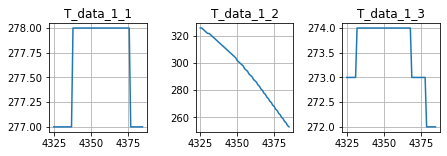

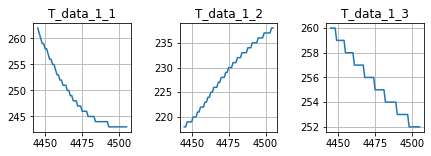

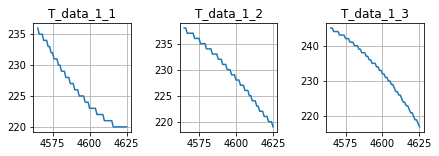

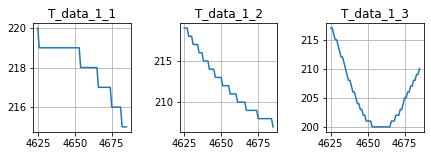

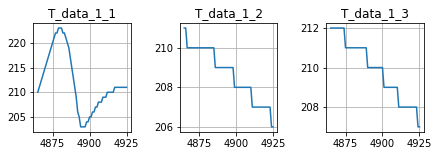

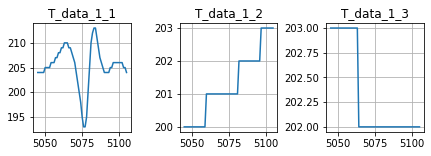

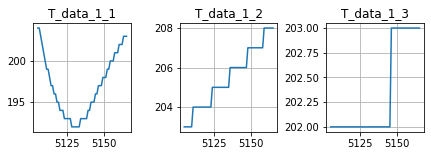

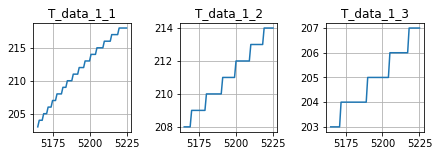

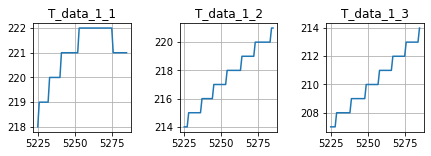

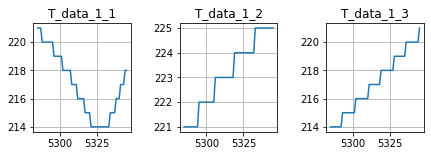

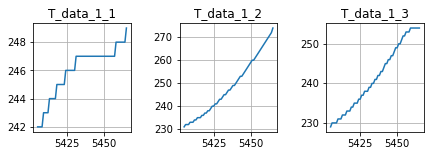

In [ ]:
for i in range(20):
    df = get_processing_data(time_begin_array[i], Y_train['date'].iloc[i])
    draw_temperatures(df, n = 1)

Видна некая корреляция между графиками, но явно обнаружить зависимость не удалось. Пытаться приблизить график теммпературы через полином (и его коэффициенты взять как фичи) или усреднять каждые 5 минут температуру (и брать в 5 раз меньше точек) не будем.

Проверим, что Y_train, Y_submit содержат в соседних строках смещённое на 1 час время, а X_data - на 1 минуту

In [ ]:
def sequentially(df, t):
    for i in range(len(df) - 1):
        if pd.Timestamp(df.iloc[i]['date']) + pd.Timedelta('1 ' + t) != pd.Timestamp(df.iloc[i + 1]['date']):
            return False, i
    return True

In [ ]:
sequentially(Y_train, t = 'hour')

True

In [ ]:
sequentially(Y_submit, t = 'hour')

True

In [ ]:
sequentially(X_data, t = 'minute')

True

**В качестве признаков возьмём все исходные данные. Затем попробуем часть из них отобрать или добавить новые**

In [ ]:
def get_features(processing_data):
    return processing_data.values[:, 1:].flatten()

In [ ]:
time_begin_array = Y_train['date'].apply(get_time_begin)

In [ ]:
time_begin_array.iloc[0], time_begin_array.iloc[-1]

('2015-01-03 23:05:00', '2018-05-03 22:05:00')

In [ ]:
X_data[X_data['date'] == time_begin_array.iloc[0]]

date  T_data_1_1  T_data_1_2  ...  T_data_5_3  H_data  AH_data
4265  2015-01-03 23:05:00         266         339  ...         239  154.87     4.73

[1 rows x 18 columns]

In [ ]:
X_data[X_data['date'] == time_begin_array.iloc[-1]]

date  T_data_1_1  ...  H_data  AH_data
1755245  2018-05-03 22:05:00         255  ...  153.89      8.9

[1 rows x 18 columns]

In [ ]:
%%time 
X = [] 
for i in range(4265, 1755245 + 1, 60):
    X.append(get_features(X_data[i: i+60]))
X = np.array(X, dtype = float)

CPU times: user 10.4 s, sys: 2.14 s, total: 12.6 s
Wall time: 12.8 s


In [12]:
y = Y_train['quality']

In [11]:
def normalize(X):
  scaler = MinMaxScaler()
  return scaler.fit_transform(X)

In [13]:
def get_CV(clf, X, y, cv = 3):
  return -cross_val_score(clf, X , y, cv=cv, scoring = 'neg_mean_absolute_error')

**Настройка модели**

Для предсказаний выберем линейную модель ElasticNet (которая содержит внутри себя Lasso, Ridge, LinearRegression, если задать соответствующие alpha, l1_ratio) 

In [ ]:
parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1), 'l1_ratio':(0, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 1)}
clf = ElasticNet(max_iter = 50000)
gs = GridSearchCV(clf, parameters, scoring = 'neg_mean_absolute_error', verbose = 1, n_jobs = -1)
gs.fit(normalize(X), y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 84.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 203.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 207.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=50000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': (0.0001, 0.001, 0.01, 0.1, 1),
                         'l1_ratio': (0, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 1)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
gs.cv_results_

{'mean_fit_time': array([9.07605514e+02, 8.85833135e+01, 6.25830892e+01, 3.82871140e+01,
        8.31294289e+00, 1.41188884e+01, 3.82755383e+01, 6.37573956e+01,
        9.48555504e+02, 9.06865354e+00, 6.16230164e+00, 3.54505720e+00,
        5.89630451e+00, 2.68098283e+00, 3.63734713e+00, 1.57366674e+01,
        8.89126573e+02, 7.11973906e-01, 6.93133879e-01, 6.54789495e-01,
        5.59235477e-01, 9.29819632e-01, 1.47947602e+00, 1.41697016e+00,
        9.25319251e+02, 2.59502983e-01, 2.45428658e-01, 2.21616268e-01,
        2.41668844e-01, 3.78344488e-01, 9.16174603e-01, 2.45692782e+00,
        8.79053392e+02, 1.84974718e-01, 1.71932364e-01, 1.68557215e-01,
        1.68771648e-01, 1.95615816e-01, 3.05114365e-01, 2.19326782e-01]),
 'mean_score_time': array([0.00988827, 0.00635819, 0.00579906, 0.00595016, 0.00469913,
        0.00525341, 0.00496321, 0.00546861, 0.01000476, 0.00581126,
        0.00513396, 0.00473366, 0.00483971, 0.00656567, 0.0049027 ,
        0.00484633, 0.01003566, 0.0062

In [ ]:
gs.best_estimator_

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=1,
           max_iter=50000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
gs.best_score_

-12.961780465735632

**Отбор признаков**

In [ ]:
X.shape

(29184, 1020)

**PCA**

In [ ]:
def search():
  for n_components in range(25, 200, 25):
    pca = PCA(n_components=100)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_pca = normalize(X_pca)
    print('n_components =', n_components)
    print(np.mean(get_CV(clf = Lasso(alpha=0.01, max_iter = 10000), X = X_pca, y = y, cv = 5)))
    print(np.mean(get_CV(clf = LinearRegression(), X = X_pca, y = y, cv = 5)))
    print(np.mean(get_CV(clf = ElasticNet(alpha=0.0001, l1_ratio = 1, max_iter = 50000), X = X_pca, y = y, cv = 5)))
    print('='*25)

In [ ]:
search()

n_components = 25
13.168015501820824
13.095629001692112
13.094421094295848
n_components = 50
13.168658380016499
13.093676136292618
13.092379936984845
n_components = 75
13.1679518858531
13.096489035656301
13.095220519508675
n_components = 100
13.167858611118888
13.094509194896677
13.093236874179102
n_components = 125
13.1679345762355
13.095129601075365
13.093927266134386
n_components = 150
13.169390827330044
13.096576738256498
13.095261456755583
n_components = 175
13.170941134118788
13.097112392092924
13.095870599551343


Видно, что лучшее качество составило 13.092 при 50 признаках

**Lasso**

In [ ]:
%%time 
clf = Lasso(alpha = 0.1, max_iter = 5000).fit(X, y)
importance = np.abs(clf.coef_)

CPU times: user 5min 6s, sys: 22.1 s, total: 5min 29s
Wall time: 2min 46s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4782247.826972498, tolerance: 6248.697834371575
  positive)


In [ ]:
feature_indices = [x[1] for x in sorted([(importance[i], i) for i in range(len(importance)) if abs(importance[i]) > 1e-9])]

In [ ]:
len(feature_indices)

323

In [ ]:
X_new = X[:, feature_indices]

In [ ]:
X_new = normalize(X_new)

In [ ]:
np.mean(get_CV(clf = Lasso(alpha=0.0001, max_iter = 10000), X = X_new, y = y, cv = 5))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1722921.836619263, tolerance: 5061.385042523665
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1703660.669594692, tolerance: 5018.902540531973
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1536130.565044269, tolerance: 4955.612556191376
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1647556.5160

13.035263330519172

Видно, что качество составило 13.035 при 323 признаках

**RandomForestRegressor**

In [ ]:
%%time
forest = RandomForestRegressor(n_estimators= 300, max_depth=8, criterion = 'mae', random_state=0).fit(X[:3000], y[:3000])

CPU times: user 1h 17min 3s, sys: 537 ms, total: 1h 17min 4s
Wall time: 1h 17min 7s


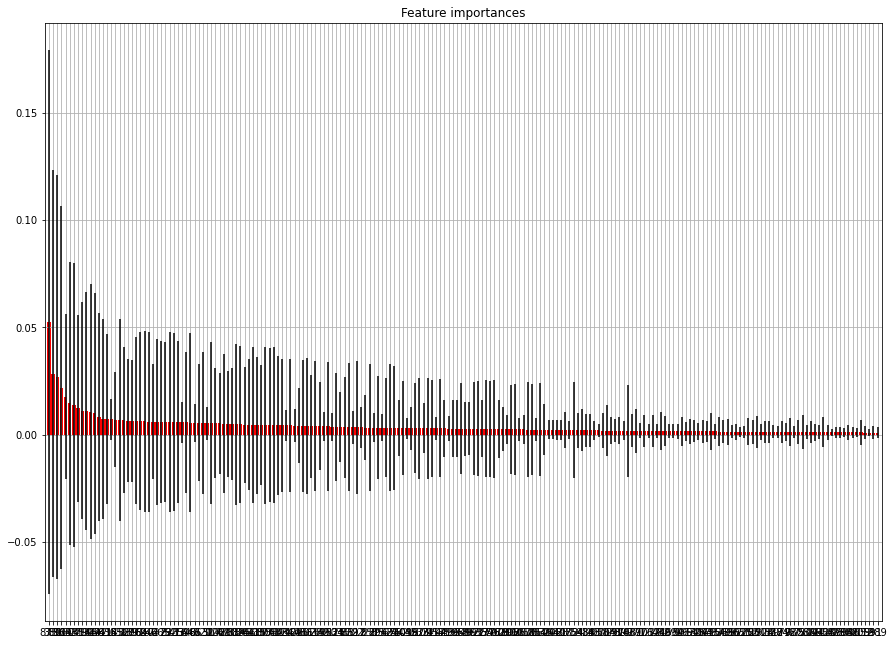

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:200]

plt.figure(figsize = (15, 11))
plt.title("Feature importances")
plt.bar(range(len(indices)), forest.feature_importances_[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), indices)
plt.xlim([-1, len(indices)])
plt.grid(True)
plt.show()

In [ ]:
X_new = X[:, indices]

In [ ]:
X_new = normalize(X_new)

In [ ]:
np.mean(get_CV(clf = ElasticNet(alpha=0.0001, l1_ratio = 1, max_iter = 50000), X = X_new, y = y, cv = 5))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284874.98076550383, tolerance: 5061.385042523665
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191156.49656572193, tolerance: 5018.902540531973
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77270.15312020015, tolerance: 4955.612556191376
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238943.591

13.319065281791671

Видно, что качество составило 13.32 при 200 признаках

**Сами построим признаки**

In [8]:
%%time 
X = [] 
for i in range(4265, 1755245 + 1, 60):
  X_data_i = X_data[i: i+60].values[:, 1:]
  deg = 9
  X_new_i = np.zeros(shape = (3 + (deg + 1), 17))
  X_new_i[0] = np.mean(X_data_i, axis = 0)
  X_new_i[1] = np.min(X_data_i, axis = 0)
  X_new_i[2] = np.max(X_data_i, axis = 0)
  for j in range(17):
    z = np.polyfit(x = np.array(range(60)), y = np.array(X_data_i[:, j], dtype = float),  deg = deg)
    X_new_i[3:, j] = z
  X.append(X_new_i.flatten())
X = np.array(X, dtype = float)

CPU times: user 1min 48s, sys: 112 ms, total: 1min 48s
Wall time: 1min 48s


In [ ]:
X_new = normalize(X)
print(np.mean(get_CV(clf = ElasticNet(alpha=0.0001, l1_ratio = 1, max_iter = 50000), X = X_new, y = y, cv = 5)))

12.961780465735638


In [ ]:
X_new.shape

(29184, 221)

Получилось качество 12.96 при 221 признаке

Также попробуем XGBoost

**XGBoost**

In [9]:
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
%%time
params = {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'loss': 'lad', 'random_state': 13}
clf = GradientBoostingRegressor(**params)

print(np.mean(get_CV(clf = GradientBoostingRegressor(**params), X = normalize(X), y = y, cv = 5)))

8.788521737371083
CPU times: user 31min 10s, sys: 258 ms, total: 31min 10s
Wall time: 31min 12s


In [ ]:
%%time
params = {'n_estimators': 80, 'max_depth': 15, 'learning_rate': 0.1, 'loss': 'lad', 'random_state': 13}
clf = GradientBoostingRegressor(**params)

print(np.mean(get_CV(clf = GradientBoostingRegressor(**params), X = normalize(X), y = y, cv = 5)))

8.569134597274347
CPU times: user 53min 4s, sys: 427 ms, total: 53min 5s
Wall time: 53min 7s


In [14]:
%%time
params = {'n_estimators': 120, 'max_depth': 15, 'learning_rate': 0.1, 'loss': 'lad', 'random_state': 13}
clf = GradientBoostingRegressor(**params)

print(np.mean(get_CV(clf = GradientBoostingRegressor(**params), X = normalize(X), y = y, cv = 5)))

8.493439260768191
CPU times: user 1h 21min 27s, sys: 508 ms, total: 1h 21min 27s
Wall time: 1h 21min 33s


Видно, что XGBoost дал наилучшее качество 8.493. Поэтому его и будем использовать

**Предсказания**

In [15]:
def create_features(start, end):
  X = [] 
  for i in range(start, end + 1, 60):
    X_data_i = X_data[i: i+60].values[:, 1:]
    deg = 9
    X_new_i = np.zeros(shape = (3 + (deg + 1), 17))
    X_new_i[0] = np.mean(X_data_i, axis = 0)
    X_new_i[1] = np.min(X_data_i, axis = 0)
    X_new_i[2] = np.max(X_data_i, axis = 0)
    for j in range(17):
      z = np.polyfit(x = np.array(range(60)), y = np.array(X_data_i[:, j], dtype = float),  deg = deg)
      X_new_i[3:, j] = z
    X.append(X_new_i.flatten())
  return np.array(X, dtype = float)

In [16]:
time_begin_array_train = Y_train['date'].apply(get_time_begin)

start = X_data[X_data['date'] == time_begin_array_train.iloc[0]].index.tolist()[0]
end = X_data[X_data['date'] == time_begin_array_train.iloc[-1]].index.tolist()[0]

In [17]:
%%time
X_train = create_features(start, end)
y_train = Y_train['quality']

CPU times: user 1min 54s, sys: 80.8 ms, total: 1min 54s
Wall time: 1min 54s


In [18]:
time_begin_array_submit = Y_submit['date'].apply(get_time_begin)

start = X_data[X_data['date'] == time_begin_array_submit.iloc[0]].index.tolist()[0]
end = X_data[X_data['date'] == time_begin_array_submit.iloc[-1]].index.tolist()[0]

In [19]:
%%time 
X_submit = create_features(start, end)

CPU times: user 22.6 s, sys: 20 ms, total: 22.6 s
Wall time: 22.6 s


In [20]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_submit = scaler.transform(X_submit)

In [21]:
params = {'n_estimators': 120, 'max_depth': 15, 'learning_rate': 0.1, 'loss': 'lad', 'random_state': 13}
clf = GradientBoostingRegressor(**params)

clf.fit(X = X_train_scaled, y = y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad',
                          max_depth=15, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=13, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
y_preds = clf.predict(X_submit)

In [23]:
solution = pd.DataFrame({"0": Y_submit['date'], '1': y_preds})
solution.to_csv("drive/My Drive/Colab Notebooks/y_preds.csv", index=False)
solution

0           1
0     2018-05-04 00:05:00  448.009304
1     2018-05-04 01:05:00  439.426851
2     2018-05-04 02:05:00  433.784402
3     2018-05-04 03:05:00  409.880564
4     2018-05-04 04:05:00  399.860460
...                   ...         ...
5803  2018-12-31 19:05:00  469.924019
5804  2018-12-31 20:05:00  472.884030
5805  2018-12-31 21:05:00  463.669515
5806  2018-12-31 22:05:00  447.350759
5807  2018-12-31 23:05:00  438.312725

[5808 rows x 2 columns]

In [ ]:
function ClickConect()
{
  console.log("Working");
  document.getElementById("file-menu").click();
}
setInterval(ClickConect, 60000);